In [12]:
from transformers import CamembertTokenizer, CamembertModel
import torch
import pandas as pd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import simplemma
langdata = simplemma.load_data('sl')

In [2]:
model = CamembertModel.from_pretrained('sloberta', output_hidden_states = True)
model.eval()

Some weights of the model checkpoint at sloberta were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertModel were not initialized from the model checkpoint at sloberta and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictio

CamembertModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(32005, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0): RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dropout): Dr

In [3]:
tokenizer = CamembertTokenizer.from_pretrained('sloberta')

In [4]:
df = pd.read_csv("all_manually_annotated.csv", index_col=0)
df.sentence1 = df.sentence1.apply(lambda x: " ".join(x.lower().split()))
df.sentence2 = df.sentence2.apply(lambda x: " ".join(x.lower().split()))
df_pos = df.loc[df["class"] == 1]
df_neg = df.loc[df["class"] == 0]
df_pos

,class,word,sentence1,sentence2
1,1,kap,ko pa zdajle ta video vidim me je pa skor kap ...,čingola da te rasvetlim bila je možganska kap ...
7,1,kap,"opis: mezgec franc, ostrovica 7, z značilno ka...",jih je blo...res... kapo dol pred njo...kot kl...
9,1,kap,silver umrl zaradi srčne kapi,"so me prosili za recept zanjo, me je skoraj ka..."
10,1,kap,univerze južna karolina predstavil raziskavo o...,z jetri ali so pred časom preživeli možgansko ...
14,1,kap,tako da smo hodili kar v anorakih in si nadeli...,"kapa nike, sport 2000, 2..999 sit"
...,...,...,...,...
558,1,vila,nekdaj zelo razvpita via veneto. še danes je r...,dediščine. hosting tega potrebuje zaradi posta...
559,1,vila,namesto penziona oliva pride vila čeranič***,"...] obširen borov gozd, posejan z vilami , km..."
560,1,vila,parc. št. 317/3 (s t.i. » vilo vogler«) ter pa...,"vložilo veliko denarja v obnovo vile, ki je po..."
561,1,vila,"ridi a... ratis), trnovlje pri vili : v štandr...",tokrat je le naredil izjemo. spal je v znameni...


In [28]:
def find_word(sent: str, word: str, encod: list):
    sent = sent.lower()
    word = word.lower()
    s_split = sent.split(" ")
    ref = []
    for i in range(len(s_split)):
        if word in s_split[i]:
            ref = tokenizer.encode(s_split[i])[1:-1]
    if ref == []:
        new_sent = [simplemma.lemmatize(t, langdata) for t in s_split]
        #print(new_sent)
        for i in range(len(new_sent)):
            if word in new_sent[i]:
                ref = tokenizer.encode(s_split[i])[1:-1]
    # print("-------------------------")
    # print(word, sent)
    # print([tokenizer._convert_id_to_token(idx) for idx in encod])
    # print([tokenizer._convert_id_to_token(idx) for idx in ref])
    t = ()
    for i in range(len(encod) - len(ref)):
        if encod[i:i+len(ref)] == ref:
            t = (i, len(ref))
    #print(t)
    return t

In [33]:
pos_diff = []
neg_diff = []

for i in df_pos.index:
    print(i)
    e1 = tokenizer.encode(df_pos["sentence1"][i])
    e2 = tokenizer.encode(df_pos["sentence2"][i])
    t1 = [tokenizer._convert_id_to_token(idx) for idx in e1]
    t2 = [tokenizer._convert_id_to_token(idx) for idx in e2]

    p1 = find_word(df_pos["sentence1"][i], df_pos["word"][i], e1)
    p2 = find_word(df_pos["sentence2"][i], df_pos["word"][i], e2)

    with torch.no_grad():
        token_ids = torch.tensor(e1).unsqueeze(0)
        vec1 = model(token_ids)[0][0][p1[0]:p1[0]+p1[1]].numpy()

        token_ids = torch.tensor(e2).unsqueeze(0)
        vec2 = model(token_ids)[0][0][p2[0]:p2[0]+p2[1]].numpy()
    m1 = np.mean(vec1, axis=0)
    m2 = np.mean(vec2, axis=0)
    res = spatial.distance.cosine(m1, m2)
    pos_diff.append(res)

for i in df_neg.index:
    print(i)
    e1 = tokenizer.encode(df_neg["sentence1"][i])
    e2 = tokenizer.encode(df_neg["sentence2"][i])
    t1 = [tokenizer._convert_id_to_token(idx) for idx in e1]
    t2 = [tokenizer._convert_id_to_token(idx) for idx in e2]

    p1 = find_word(df_neg["sentence1"][i], df_neg["word"][i], e1)
    p2 = find_word(df_neg["sentence2"][i], df_neg["word"][i], e2)

    with torch.no_grad():
        token_ids = torch.tensor(e1).unsqueeze(0)
        vec1 = model(token_ids)[0][0][p1[0]:p1[0]+p1[1]].numpy()

        token_ids = torch.tensor(e2).unsqueeze(0)
        vec2 = model(token_ids)[0][0][p2[0]:p2[0]+p2[1]].numpy()
    m1 = np.mean(vec1, axis=0)
    m2 = np.mean(vec2, axis=0)
    res = spatial.distance.cosine(m1, m2)
    neg_diff.append(res)

1
7
9
10
14
15
18
19
21
23
24
27
29
34
37
38
42
44
47
48
49
51
52
54
59
60
61
63
65
66
69
75
76
78
79
84
86
87
89
94
95
96
97
98
100
104
108
110
116
117
118
120
121
122
124
130
132
134
140
143
150
154
155
156
158
159


/home/nejc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nejc/.local/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


160
161
163
164
165
169
170
171
173
174
176
177
178
179
181
182
183
184
188
191
192
194
197
198
199
201
205
209
211
215
219
221
236
238
246
248
250
253
254
255
256
258
259
260
262
263
264
266
267
268
269
270
271
272
273
274
277
278
281
286
287
288
289
290
292
293
295
299
302
303
304
305
311
312
313
314
316
319
321
322
328
330
338
339
340
343
344
346
361
367
373
376
379
381
382
383
387
388
391
392
398
406
407
408
410
413
418
420
423
425
426
435
436
437
443
444
452
453
458
459
461
465
466
469
473
479
483
484
486
487
493
495
497
498
499
500
501
503
505
507
508
509
510
511
512
515
516
519
523
529
533
534
536
537
543
545
547
548
549
550
551
553
555
557
558
559
560
561
562
0
2
3
4
5
6
8
11
12
13
16
17
20
22
25
26
28
30
31
32
33
35
36
39
40
41
43
45
46
50
53
55
56
57
58
62
64
67
68
70
71
72
73
74
77
80
81
82
83
85
88
90
91
92
93
99
101
102
103
105
106
107
109
111
112
113
114
115
119
123
125
126
127
128
129
131
133
135
136
137
138
139
141
142
144
145
146
147
148
149
151
152
153
157
162
166
167

In [35]:
print(neg_diff)

[0.22642028331756592, 0.08742767572402954, 0.3150207996368408, 0.4057033061981201, 0.4303714632987976, 0.24218475818634033, 0.26036709547042847, 0.3097383975982666, 0.2721598744392395, 0.16493719816207886, 0.30629873275756836, 0.21964067220687866, 0.42639774084091187, 0.22052240371704102, 0.5796404182910919, 0.32620400190353394, 0.3555590510368347, 0.3998594284057617, 0.5124630331993103, 0.22470486164093018, 0.37188881635665894, 0.33760082721710205, 0.2722521424293518, 0.2094528079032898, 0.2941167950630188, 0.36723679304122925, 0.38135039806365967, 0.4375753402709961, 0.20782411098480225, 0.44180864095687866, 0.5077777206897736, 0.5036455988883972, 0.3188434839248657, 0.5013689696788788, 0.29860955476760864, 0.1792352795600891, 0.3976130485534668, 0.3613291382789612, 0.21388602256774902, 0.32297587394714355, 0.1005294919013977, 0.4449079632759094, 0.2628830075263977, 0.15967309474945068, 0.26440006494522095, 0.3273389935493469, 0.3510403633117676, 0.3199698328971863, 0.175350785255432

In [36]:
test1 = list(filter(lambda a: a != 0, neg_diff))
test1

[0.22642028331756592,
 0.08742767572402954,
 0.3150207996368408,
 0.4057033061981201,
 0.4303714632987976,
 0.24218475818634033,
 0.26036709547042847,
 0.3097383975982666,
 0.2721598744392395,
 0.16493719816207886,
 0.30629873275756836,
 0.21964067220687866,
 0.42639774084091187,
 0.22052240371704102,
 0.5796404182910919,
 0.32620400190353394,
 0.3555590510368347,
 0.3998594284057617,
 0.5124630331993103,
 0.22470486164093018,
 0.37188881635665894,
 0.33760082721710205,
 0.2722521424293518,
 0.2094528079032898,
 0.2941167950630188,
 0.36723679304122925,
 0.38135039806365967,
 0.4375753402709961,
 0.20782411098480225,
 0.44180864095687866,
 0.5077777206897736,
 0.5036455988883972,
 0.3188434839248657,
 0.5013689696788788,
 0.29860955476760864,
 0.1792352795600891,
 0.3976130485534668,
 0.3613291382789612,
 0.21388602256774902,
 0.32297587394714355,
 0.1005294919013977,
 0.4449079632759094,
 0.2628830075263977,
 0.15967309474945068,
 0.26440006494522095,
 0.3273389935493469,
 0.351040363

In [37]:
print(np.mean(pos_diff, axis=0))
print(max(pos_diff))
print(min(pos_diff))
print()
print(np.mean(test1, axis=0))
print(max(test1))
print(min(test1))

print()
print(np.std(pos_diff, axis=0))
print(np.std(test1, axis=0))
#0.16

0.18206852217938038
0.5861902236938477
0

0.24836452253396502
0.7955758422613144
0.08038550615310669

0.07885291298366726
0.10656863746551606


In [18]:
print(simplemma.lemmatize("karte", langdata))

karta


In [27]:
i = 102
e1 = tokenizer.encode(df["sentence1"][i])
e2 = tokenizer.encode(df["sentence2"][i])
t1 = [tokenizer._convert_id_to_token(idx) for idx in e1]
t2 = [tokenizer._convert_id_to_token(idx) for idx in e2]

p1 = find_word(df["sentence1"][i], df["word"][i], e1)
p2 = find_word(df["sentence2"][i], df["word"][i], e2)

with torch.no_grad():
    token_ids = torch.tensor(e1).unsqueeze(0)
    vec1 = model(token_ids)[0][0][p1[0]:p1[0]+p1[1]].numpy()

    token_ids = torch.tensor(e2).unsqueeze(0)
    vec2 = model(token_ids)[0][0][p2[0]:p2[0]+p2[1]].numpy()
m1 = np.mean(vec1, axis=0)
m2 = np.mean(vec2, axis=0)
res = spatial.distance.cosine(m1, m2)
print(res, df["class"][i])

-------------------------
karta 22. hindujsko: »mayn toojh ko py r karta hun.« 53. •vedsko: »jag
['<s>', '▁22.', '▁hi', 'ndu', 'jsko', ':', '▁»', 'ma', 'yn', '▁to', 'o', 'jh', '▁ko', '▁p', 'y', '▁r', '▁karta', '▁h', 'un', '.«', '▁53.', '▁•', 'ved', 'sko', ':', '▁»', 'ja', 'g', '</s>']
['▁karta']
(16, 1)
['on', 'temen', 'stran', 'sila', 'za', 'vedno', 'premagana.', 'rabiti', 'kdo', 'karta', '?']
-------------------------
karta je temna stran sile za vedno premagana. rab kdo karte ?
['<s>', '▁je', '▁tem', 'na', '▁stran', '▁sile', '▁za', '▁vedno', '▁premaga', 'na', '.', '▁ra', 'b', '▁kdo', '▁karte', '▁?', '</s>']
['▁karte']
(14, 1)
0.16005539894104004 0


In [38]:
cls = []

for i in df.index:
    print(i)
    e1 = tokenizer.encode(df["sentence1"][i])
    e2 = tokenizer.encode(df["sentence2"][i])
    t1 = [tokenizer._convert_id_to_token(idx) for idx in e1]
    t2 = [tokenizer._convert_id_to_token(idx) for idx in e2]

    p1 = find_word(df["sentence1"][i], df["word"][i], e1)
    p2 = find_word(df["sentence2"][i], df["word"][i], e2)

    with torch.no_grad():
        token_ids = torch.tensor(e1).unsqueeze(0)
        vec1 = model(token_ids)[0][0][p1[0]:p1[0]+p1[1]].numpy()

        token_ids = torch.tensor(e2).unsqueeze(0)
        vec2 = model(token_ids)[0][0][p2[0]:p2[0]+p2[1]].numpy()
    m1 = np.mean(vec1, axis=0)
    m2 = np.mean(vec2, axis=0)
    res = spatial.distance.cosine(m1, m2)
    print(res, df["class"][i])
    if res < 0.21:
        cls.append(1)
    else:
        cls.append(0)

0
0.22642028331756592 0
1
0.1984514594078064 1
2
0.08742767572402954 0
3
0.3150207996368408 0
4
0.4057033061981201 0
5
0.4303714632987976 0
6
0.24218475818634033 0
7
0.12522941827774048 1
8
0.26036709547042847 0
9
0.2790430188179016 1
10
0.04555028676986694 1
11
0.3097383975982666 0
12
0.2721598744392395 0
13
0.16493719816207886 0
14
0.3045370578765869 1
15
0.22638201713562012 1
16
0.30629873275756836 0
17
0.21964067220687866 0
18
0.09362548589706421 1
19
0.11762714385986328 1
20
0.42639774084091187 0
21
0.17041808366775513 1
22
0.22052240371704102 0
23
0.23228400945663452 1
24
0.13727205991744995 1
25
0.5796404182910919 0
26
0.32620400190353394 0
27
0.18299657106399536 1
28
0.3555590510368347 0
29
0.18083405494689941 1
30
0.3998594284057617 0
31
0.5124630331993103 0
32
0.22470486164093018 0
33
0.37188881635665894 0
34
0.2283814549446106 1
35
0.33760082721710205 0
36
0.2722521424293518 0
37
0.1679520606994629 1
38
0.23694181442260742 1
39
0.2094528079032898 0
40
0.2941167950630188 0
41

/home/nejc/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nejc/.local/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


0.07068061828613281 1
160
0.07651418447494507 1
161
0.15449309349060059 1
162
0.30686819553375244 0
163
0.2372017502784729 1
164
0.2254541516304016 1
165
0.1087186336517334 1
166
0.19459038972854614 0
167
0 0
168
0 0
169
0.2133517861366272 1
170
0.14096641540527344 1
171
0.25632625818252563 1
172
0.33102625608444214 0
173
0.176702082157135 1
174
0.23615926504135132 1
175
0.21657991409301758 0
176
0.1754777431488037 1
177
0.13994914293289185 1
178
0.1851465106010437 1
179
0.25761085748672485 1
180
0 0
181
0.11941778659820557 1
182
0.30362939834594727 1
183
0.22841739654541016 1
184
0.19777309894561768 1
185
0.23903316259384155 0
186
0 0
187
0.2186092734336853 0
188
0.16336041688919067 1
189
0 0
190
0 0
191
0.16722679138183594 1
192
0.27804887294769287 1
193
0.2570815086364746 0
194
0.20371150970458984 1
195
0.1864638328552246 0
196
0.2680094242095947 0
197
0.19277477264404297 1
198
0.22489029169082642 1
199
0.23630279302597046 1
200
0.21749728918075562 0
201
0.226465106010437 1
202
0.16

(0.5811090658076392, 0.5820668693009119, 0.5689849830961553, None)


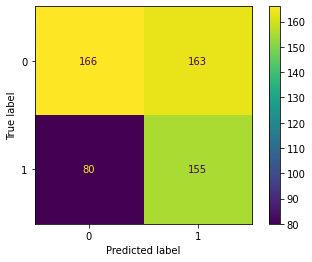

In [41]:
from sklearn import metrics
import matplotlib.pyplot as plt

base = df["class"]
classes = [0,1]
c = metrics.confusion_matrix(base, cls, labels=classes)
disp = metrics.ConfusionMatrixDisplay(c, display_labels=classes)
disp.plot()
print(metrics.precision_recall_fscore_support(base, cls, average="macro"))
plt.savefig("cm_bert.jpg")